In [2]:
%matplotlib inline
import glob, os, sys, timeit
import matplotlib
import numpy as np
from astropy.io import fits,ascii
from astropy import constants, units as u
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from os import path
import os
from urllib import request

from pyqsofit.PyQSOFit import QSOFit
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, TriAnalyzer

import warnings

multiAGNpath="/disk/bifrost/yuanze/multiAGN"
psname1="ESO353"
psname2="-9"
field=psname1+psname2
stab = ascii.read(multiAGNpath+"/sources.list",format="ipac")
field=psname1+psname2
sentry = stab[stab["Field"]==field]

#redshift=0.0312
redshift=sentry["z_sys"][0]
datapath=os.path.join(multiAGNpath,psname1+psname2)

path_out=datapath+"/field_scan"
path_ex = datapath #os.path.join(pyqsofit.__path__[0], '..', 'example')

In [3]:
redshift

0.0169

In [4]:

rootname=field+"bin20-SNRcut"
gistoutpath=datapath+"/gist/results/"+rootname

dirprefix=os.path.join(gistoutpath,rootname)

mask = fits.open(dirprefix+'_mask.fits')[1].data.MASK_DEFUNCT
maskedSpaxel = np.array(mask, dtype=bool)
#nmask=table_hdu[1].data.FLUX<0
#maskedSpaxel=nmask|masked
# Read bintable
table_hdu = fits.open(dirprefix+'_table.fits')
X           = np.array( table_hdu[1].data.X[~maskedSpaxel] )
Y           = np.array( table_hdu[1].data.Y[~maskedSpaxel] )
FLUX        = np.array( table_hdu[1].data.FLUX[~maskedSpaxel] ) 
binNum_long = np.array( table_hdu[1].data.BIN_ID[~maskedSpaxel] )
ubins       = np.unique( np.abs(binNum_long) )
pixelsize   = table_hdu[0].header['PIXSIZE']

Spectra    = fits.open(dirprefix+'_BinSpectra.fits')[1].data.SPEC
ESpectra = fits.open(dirprefix+'_BinSpectra.fits')[1].data.ESPEC
Lambda     = fits.open(dirprefix+'_BinSpectra.fits')[2].data.LOGLAM
nbins           = Spectra.shape[0]


Voronoi bin: 1 / 1658
Voronoi bin: 2 / 1658
Voronoi bin: 3 / 1658
Voronoi bin: 4 / 1658
Voronoi bin: 5 / 1658
Voronoi bin: 6 / 1658
Voronoi bin: 7 / 1658
Voronoi bin: 8 / 1658
Voronoi bin: 9 / 1658
Voronoi bin: 10 / 1658
Voronoi bin: 11 / 1658
Voronoi bin: 12 / 1658
Voronoi bin: 13 / 1658
Voronoi bin: 14 / 1658
Voronoi bin: 15 / 1658
Voronoi bin: 16 / 1658
Voronoi bin: 17 / 1658
Voronoi bin: 18 / 1658
Voronoi bin: 19 / 1658
Voronoi bin: 20 / 1658
Voronoi bin: 21 / 1658
Voronoi bin: 22 / 1658
Voronoi bin: 23 / 1658
Voronoi bin: 24 / 1658
Voronoi bin: 25 / 1658
Voronoi bin: 26 / 1658
Voronoi bin: 27 / 1658
Voronoi bin: 28 / 1658
Voronoi bin: 29 / 1658
Voronoi bin: 30 / 1658
Voronoi bin: 31 / 1658
Voronoi bin: 32 / 1658
Voronoi bin: 33 / 1658
Voronoi bin: 34 / 1658
Voronoi bin: 35 / 1658
Voronoi bin: 36 / 1658
Voronoi bin: 37 / 1658
Voronoi bin: 38 / 1658
Voronoi bin: 39 / 1658
Voronoi bin: 40 / 1658
Voronoi bin: 41 / 1658
Voronoi bin: 42 / 1658
Voronoi bin: 43 / 1658
Voronoi bin: 44 / 16

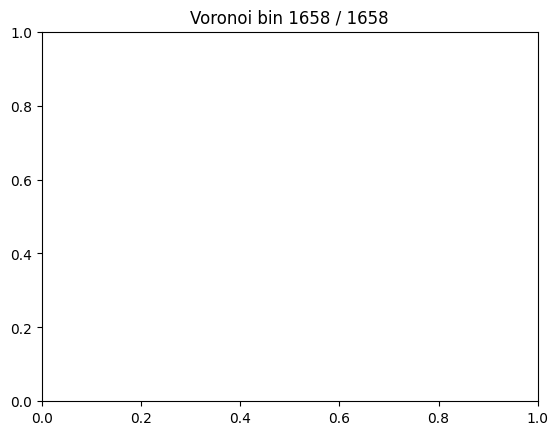

In [5]:
qlist=[]

nbins=np.max(ubins)+1
#nbins=3
#tbin=44
for j in range(nbins):
#for j in [tbin]:
    #w = binNum_long == j
    flux = np.float64(Spectra[j,:])
    err = np.float64(ESpectra[j,:])
    #mask= (flux>0.0001)# & mask0
    q_temp = QSOFit(np.float64(np.exp(Lambda))*(1+redshift), flux, err, redshift, path=path_ex)
    
    q_temp.Fit(name=None,  # customize the name of given targets. Default: plate-mjd-fiber
          # prepocessing parameters
          nsmooth=1,  # do n-pixel smoothing to the raw input flux and err spectra
          and_mask=False,  # delete the and masked pixels
          or_mask=False,  # delete the or masked pixels
          reject_badpix=False,  # reject 10 most possible outliers by the test of pointDistGESD
          deredden=True,  # correct the Galactic extinction
          wave_range=None,  # trim input wavelength
          wave_mask=None,  # 2-D array, mask the given range(s)

          # host decomposition parameters
          decompose_host=False,  # If True, the host galaxy-QSO decomposition will be applied
          host_prior=True, # If True, the code will adopt prior-informed method to assist decomposition. Currently, only 'CZBIN1' and 'DZBIN1' model for QSO PCA are available. And the model for galaxy must be PCA too.
          host_prior_scale=0.2, # scale of prior panelty. Usually, 0.2 works fine for SDSS spectra. Adjust it smaller if you find the prior affect the fitting results too much.

          host_line_mask=True, # If True, the line region of galaxy will be masked when subtracted from original spectra.
          decomp_na_mask=True, # If True, the narrow line region will be masked when perform decomposition
          qso_type='CZBIN1', # PCA template name for quasar
          npca_qso=10, # numebr of quasar templates
          host_type='PCA', # template name for galaxy
          npca_gal=5, # number of galaxy templates
          
          # continuum model fit parameters
          Fe_uv_op=False,  # If True, fit continuum with UV and optical FeII template
          poly=True,  # If True, fit continuum with the polynomial component to account for the dust reddening
          BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
          initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
          rej_abs_conti=False,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
          n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.

          # emission line fit parameters
          linefit=True,  # If True, the emission line will be fitted
          rej_abs_line=False,
          # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines

          # fitting method selection
          MC=False,
          # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
          MCMC=False,
          # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
          nsamp=200,
          # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)

          # advanced fitting parameters
          param_file_name=multiAGNpath+'/qsopar_field.fits',  # Name of the qso fitting parameter FITS file.
          nburn=20,  # The number of burn-in samples to run MCMC chain
          nthin=10,  # To set the MCMC chain returns every n samples
          epsilon_jitter=0.,
          # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)

          # customize the results
          save_result=False,  # If True, all the fitting results will be saved to a fits file
          save_fits_name=f"bin{j:d}",  # The output name of the result fits
          save_fits_path=path_out,  # The output path of the result fits
          plot_fig=False,  # If True, the fitting results will be plotted
          save_fig=False,  # If True, the figure will be saved
          plot_corner=False,  # Whether or not to plot the corner plot results if MCMC=True

          # debugging mode
          verbose=False,  # turn on (True) or off (False) debugging output

          # sublevel parameters for figure plot and emcee
          kwargs_plot={
              'save_fig_path': '.',  # The output path of the figure
              'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
          },
          kwargs_conti_emcee={},
          kwargs_line_emcee={})
    #np.exp(s.ln_lam_gal)
 #   goodpixels0=np.flatnonzero(mask)
#    pp, bestfit_template = fit_and_clean(stars_templates, galaxy, velscale, start,goodpixels0, lam_gal, sps.lam_temp)
    try:
        fwhm, sigma, ew, peak, area, snr = q_temp.line_prop_from_name(f'OIII5007c', 'narrow')
    except:
        snr=0.01
        print("warning: no detection of OIII5007c: setting snr=0.01")
    plt.close()
    if snr < 1:
        print("warning: low S/N")
        q_temp.Fit(name=None,  # customize the name of given targets. Default: plate-mjd-fiber
              # prepocessing parameters
              nsmooth=1,  # do n-pixel smoothing to the raw input flux and err spectra
              and_mask=False,  # delete the and masked pixels
              or_mask=False,  # delete the or masked pixels
              reject_badpix=False,  # reject 10 most possible outliers by the test of pointDistGESD
              deredden=True,  # correct the Galactic extinction
              wave_range=None,  # trim input wavelength
              wave_mask=None,  # 2-D array, mask the given range(s)
    
              # continuum model fit parameters
              Fe_uv_op=False,  # If True, fit continuum with UV and optical FeII template
              poly=True,  # If True, fit continuum with the polynomial component to account for the dust reddening
              BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
              initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
              rej_abs_conti=False,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
              n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.
    
              # emission line fit parameters
              linefit=True,  # If True, the emission line will be fitted
              rej_abs_line=False,
              # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines
    
              # fitting method selection
              MC=False,
              # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
              MCMC=False,
              # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
              nsamp=200,
              # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)
    
              # advanced fitting parameters
              param_file_name=multiAGNpath+'/qsopar_field_lowsn.fits',  # Name of the qso fitting parameter FITS file.
              nburn=20,  # The number of burn-in samples to run MCMC chain
              nthin=10,  # To set the MCMC chain returns every n samples
              epsilon_jitter=0.,
              # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)
    
              # customize the results
              save_result=False,  # If True, all the fitting results will be saved to a fits file
              save_fits_name=f"bin{j:d}",  # The output name of the result fits
              save_fits_path=path_out,  # The output path of the result fits
              plot_fig=False,  # If True, the fitting results will be plotted
              save_fig=False,  # If True, the figure will be saved
              plot_corner=False,  # Whether or not to plot the corner plot results if MCMC=True
    
              # debugging mode
              verbose=False,  # turn on (True) or off (False) debugging output
    
              # sublevel parameters for figure plot and emcee
              kwargs_plot={
                  'save_fig_path': '.',  # The output path of the figure
                  'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
              },
              kwargs_conti_emcee={},
              kwargs_line_emcee={})
    qlist.append(q_temp)
    #optimal_templates[:, j] = bestfit_template

    #light_weights = pp.weights.reshape(reg_dim)
    #lg_age_bin[j], metalbin[j] = sps.mean_age_metal(light_weights)

    print(f'Voronoi bin: {j + 1} / {nbins}')
    plt.title(f"Voronoi bin {j + 1} / {nbins}")

In [8]:
line_list = np.rec.array([
    (6300.30, 'Ha', 4640, 6800, 'OI6300',   1, 0.0, 0.0, 1e10, 1e-4, 1.e-6, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6564.61, 'Ha', 6400, 6800, 'Ha_na',   1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 6400, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 5e-3, 1, 1, 1, 0.001, 1),
    (6585.28, 'Ha', 6400, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 5e-3, 1, 1, 1, 0.003, 1),
    (6718.29, 'Ha', 6400, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),
    (6732.67, 'Ha', 6400, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),
#FWHM = 2.355*2.3e-4*c0.
#    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3,  4e-4,  0.05,        0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Hb', 4640, 5100, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169,     0.01, 1, 1, 0, 0.002, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007', 1, 0.0, 0.0, 1e10, 1e-3, 1.e-5, 0.00169, 0.01, 1, 1, 0, 0.004, 1)],
    formats='float32,    <U32,  float32, float32,      <U32,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')
line_properties={}

In [9]:
c = constants.c.to(u.km/u.s).value  # speed of light in km/s

linesoi=["OIII5007","Ha_na","Hb_na","NII6585","SII6718","SII6732","OI6300"]
#line=linesoi[1:]
snrcut=0.1
for line in linesoi:
    fwhmlist=[]
    arealist=[]
    vpeclist=[]

    bvpeclist=[]
    bfwhmlist=[]
    snrlist=[]
    for i,q in enumerate(qlist):
        if i==0:
            line_properties[line]=[]
        try:
            wfwhm, wsigma, wew, wpeak, warea, wsnr = q.line_prop_from_name(f'{line:s}w', 'narrow')
        except:
            print("warning: unsuccessful line fit for wind component")
            wsnr=0.
        select=line_list['linename']==line
        line_lam=line_list["lambda"][select][0]
        if line == "OIII5007":
            try:
                fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(f'{line:s}c', 'narrow')
            except:
                print("warning: unsuccessful line fit for core component")
                snr=0.
        else:
            try:
                fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(f'{line:s}', 'narrow')
            except:
                print("warning: unsuccessful line fit for core component")
                snr=0.
        if wsnr<snrcut and snr>snrcut:
            linec=peak
            blinec=peak
            lfwhm=fwhm
            bfwhm=fwhm
            ssnr=snr
        elif wsnr>snrcut and snr<snrcut:
            linec=wpeak
            blinec=wpeak
            lfwhm=wfwhm
            bfwhm=wfwhm
            ssnr=wsnr
        elif wsnr>snrcut and snr>snrcut:
            fwhms=np.array([fwhm,wfwhm])
            linecs=np.array([peak,wpeak])
            linec=(area*peak+warea*wpeak)/(area+warea)
            lfwhm=(area*fwhm+warea*wfwhm)/(area+warea)
            mind=np.argmax(fwhms)
            bfwhm=fwhms[mind]
            blinec=linecs[mind]
            ssnr=np.max([wsnr,snr])
        else:
            print("warning, all nan")
            linec=np.nan
            lfwhm=np.nan
            bfwhm=np.nan
            blinec=np.nan
            ssnr=0.
        znew = linec/line_lam-1
        bznew = blinec/line_lam-1
        vpec = np.log((1+znew))*c
        bvpec = np.log((1+bznew))*c
        #vpec = znew*c
        vpeclist.append(vpec)
        bvpeclist.append(bvpec)
        snrlist.append(ssnr)
        arealist.append(warea+area)
        fwhmlist.append(lfwhm)
        bfwhmlist.append(bfwhm)
    #line_properties[line].append([[linec,vpec],[fwhm,sigma,ew,peak,area,snr],[wfwhm, wsigma, wew, wpeak, warea, wsnr]])
    line_properties[line+"_vpec"]=vpeclist.copy()
    line_properties[line+"_broad_vpec"]=bvpeclist.copy()
    line_properties[line+"_broad_fwhm"]=bfwhmlist.copy()
    line_properties[line+"_snr"]=snrlist.copy()
    line_properties[line+"_fwhm"]=fwhmlist.copy()
    line_properties[line+"_area"]=arealist.copy()

warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all nan
warning, all n

Narrow [OIII]5007:
FWHM (km/s) 357.7
Sigma (km/s) 149.5
EW (A) 24.5
Peak (A) 5004.2
S/N 25.8
Area (10^(-17) erg/s/cm^2) 2531.7

Narrow Hb:
FWHM (km/s) 357.7
Sigma (km/s) 149.5
EW (A) 3.8
Peak (A) 4858.8
S/N 3.8
Area (10^(-17) erg/s/cm^2) 371.2



Text(0, 0.5, '$\\rm f_{\\lambda}$ ($\\rm 10^{-17} erg\\;s^{-1}\\;cm^{-2}\\;\\AA^{-1}$)')

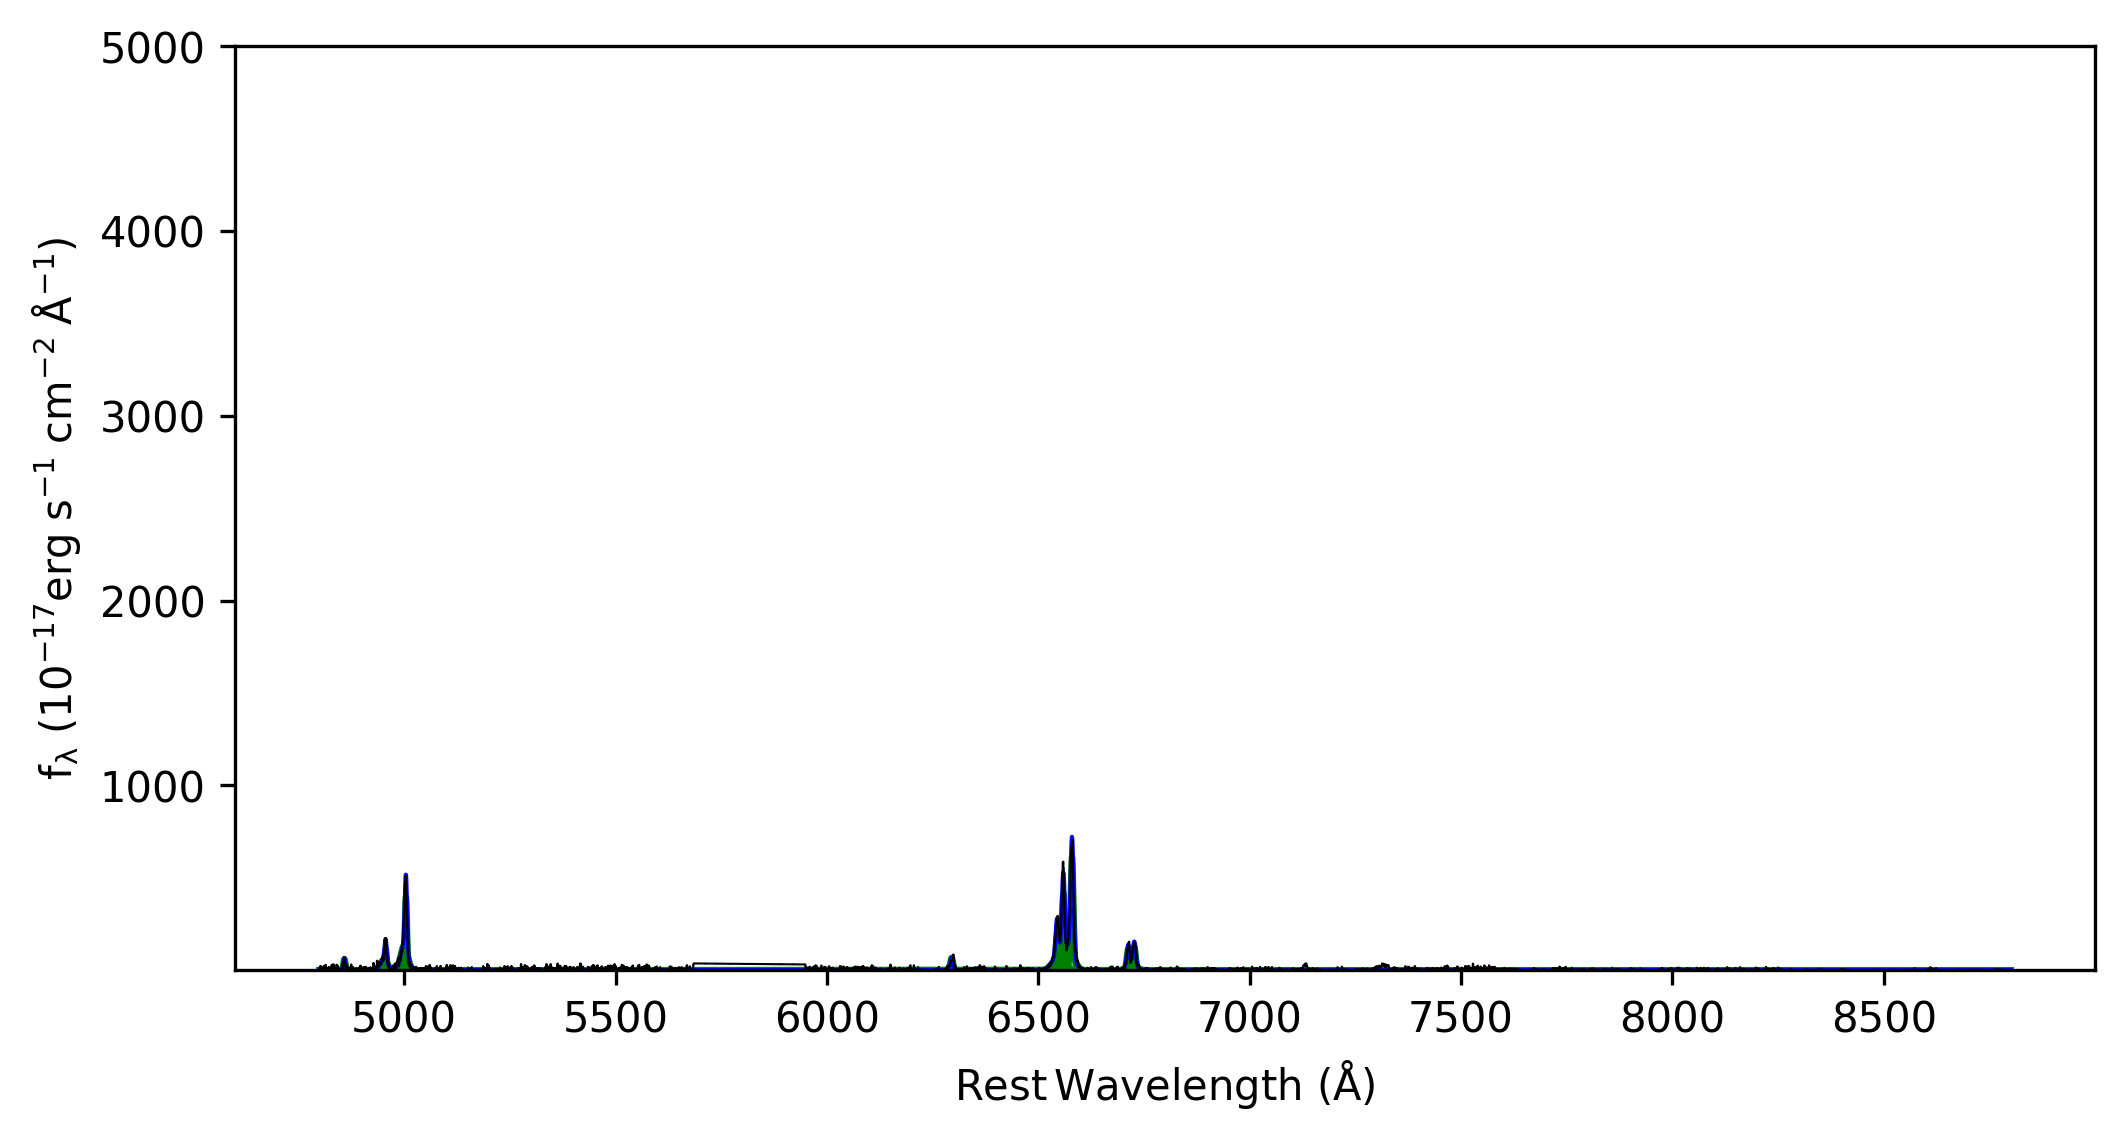

In [10]:
tbin=0
q=qlist[tbin]
#q=q_temp
# increase the cut-off voronoi S/N?
# center region is having too low S/N
fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name('OIII5007c', 'narrow')
print("Narrow [OIII]5007:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("S/N", np.round(snr, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")


fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name('Hb_na', 'narrow')

print("Narrow Hb:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("S/N", np.round(snr, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")

fig, ax = plt.subplots(1, 1,figsize=(8,4), dpi=300)
plt.subplots_adjust(wspace=0.5)
#q=q_mle

#q.set_mpl_style( tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0)

if q.MCMC:
    gauss_result = q.gauss_result[::2]
else:
    gauss_result = q.gauss_result
#plt.subplot(111)
ax=ax
# Plot individual line components
for p in range(int(len(gauss_result) / 3)):
    if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

# Plot total line model
ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
ax.step(q.wave, q.line_flux, 'k',lw=0.5)
#ax.step(q.wave,q.err)
#ax.set_xlim(6400, 7000)
ax.set_ylim(1e-4, 5000)
#ax.set_yscale("log")
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize=10)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize=10)

In [29]:


result      = np.zeros((len(ubins),6))
#result[:,0] = np.array( line_properties["Ha_na_vpec"] )
#result[:,1] = np.array( line_properties["Ha_na_fwhm"])
#result[:,2] = np.array( line_properties["OIII5007_vpec"]    )
#result[:,3] = np.array( line_properties["OIII5007_fwhm"])
#result[:,0] = np.array( line_properties["NII6585_vpec"])

result[:,0] = np.array( line_properties["Ha_na_broad_vpec"] )
result[:,1] = np.array( line_properties["Ha_na_broad_fwhm"])
result[:,2] = np.array( line_properties["OIII5007_broad_vpec"] )
result[:,3] = np.array( line_properties["OIII5007_broad_fwhm"])
result[:,4] = np.array( np.array(line_properties["Ha_na_area"])/np.array(line_properties["Hb_na_area"]))
result[:,5] = np.array( line_properties["Ha_na_area"])

# =============== construct BPT map=====================#
"""
result[:,0] = np.array(line_properties["NII6585_area"])
result[:,1] = np.array(line_properties["OIII5007_area"])
result[:,2] = np.array(line_properties["Ha_na_area"])
result[:,3] = np.array(line_properties["Hb_na_area"])
result[:,4] =  np.array(line_properties["SII6718_area"])+np.array(line_properties["SII6732_area"])
result[:,5] = np.array(line_properties["NII6585_broad_fwhm"])
"""
#EBV=2.5/1.163*np.log10(((all_area['Ha_naw']+all_area['Ha_na'])/(all_area['Hb_naw']+all_area['Hb_na'])/2.68))


result_long  = np.zeros( (len(binNum_long), result.shape[1]) ); result_long[:,:] = np.nan
surface_density=True
for ii in range( len(ubins) ):
    idx = np.where( ubins[ii] == binNum_long )[0]
    result_long[idx,:]  = result[ii,:]
    #Nbins=len(idx)
    if surface_density:
        result_long[idx,5]/=(len(idx)*pixelsize**2)
result = result_long
#result[:,0] = result[:,0] - np.nanmedian( result[:,0] )


padding=0.0
xmin = np.nanmin(X)-padding;  xmax = np.nanmax(X)+padding
ymin = np.nanmin(Y)-padding;  ymax = np.nanmax(Y)+padding
npixels_x = int( np.round( (xmax - xmin)/pixelsize ) + 1 )
npixels_y = int( np.round( (ymax - ymin)/pixelsize ) + 1 )
i = np.array( np.round( (X - xmin)/pixelsize ), dtype=int )
j = np.array( np.round( (Y - ymin)/pixelsize ), dtype=int )


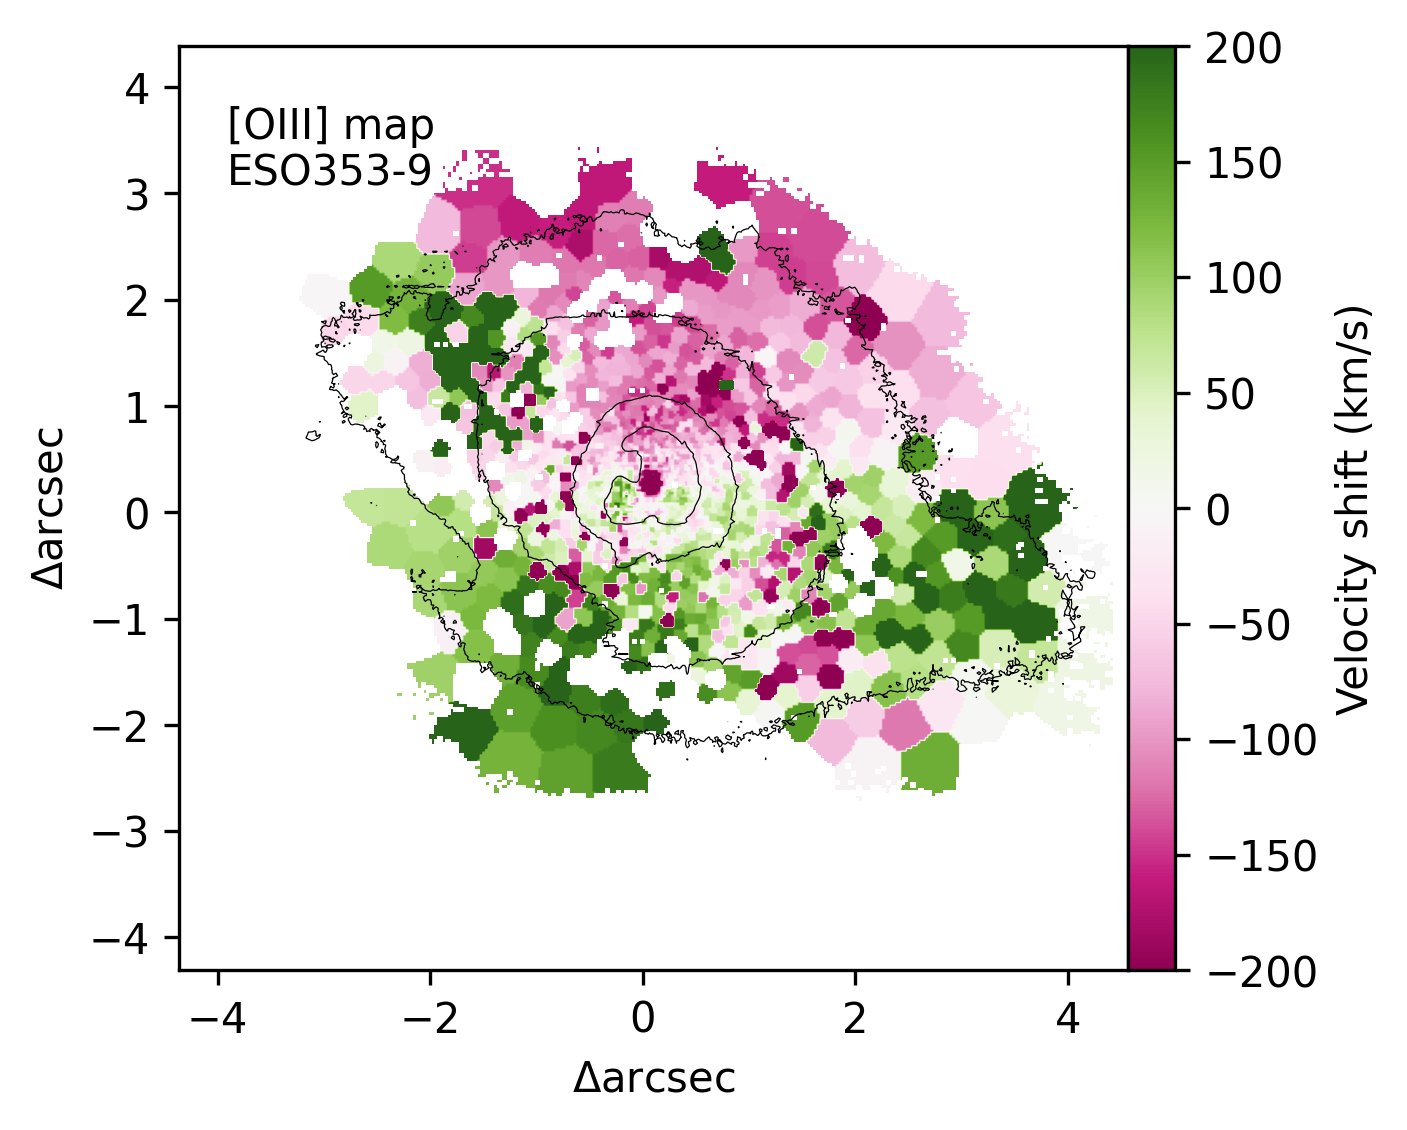

In [62]:
from astropy.stats import sigma_clipped_stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = result[:,2]-np.nanmedian(result[:,2])

fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=-200
vmax=200
cmap = plt.cm.PiYG
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(image), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"Velocity shift (km/s)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=4.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"[OIII]"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
fig.savefig(datapath+"/fig/{}_vshift_broad_map.pdf".format(line))

In [312]:
np.nanmean(image)

68812.4713142179

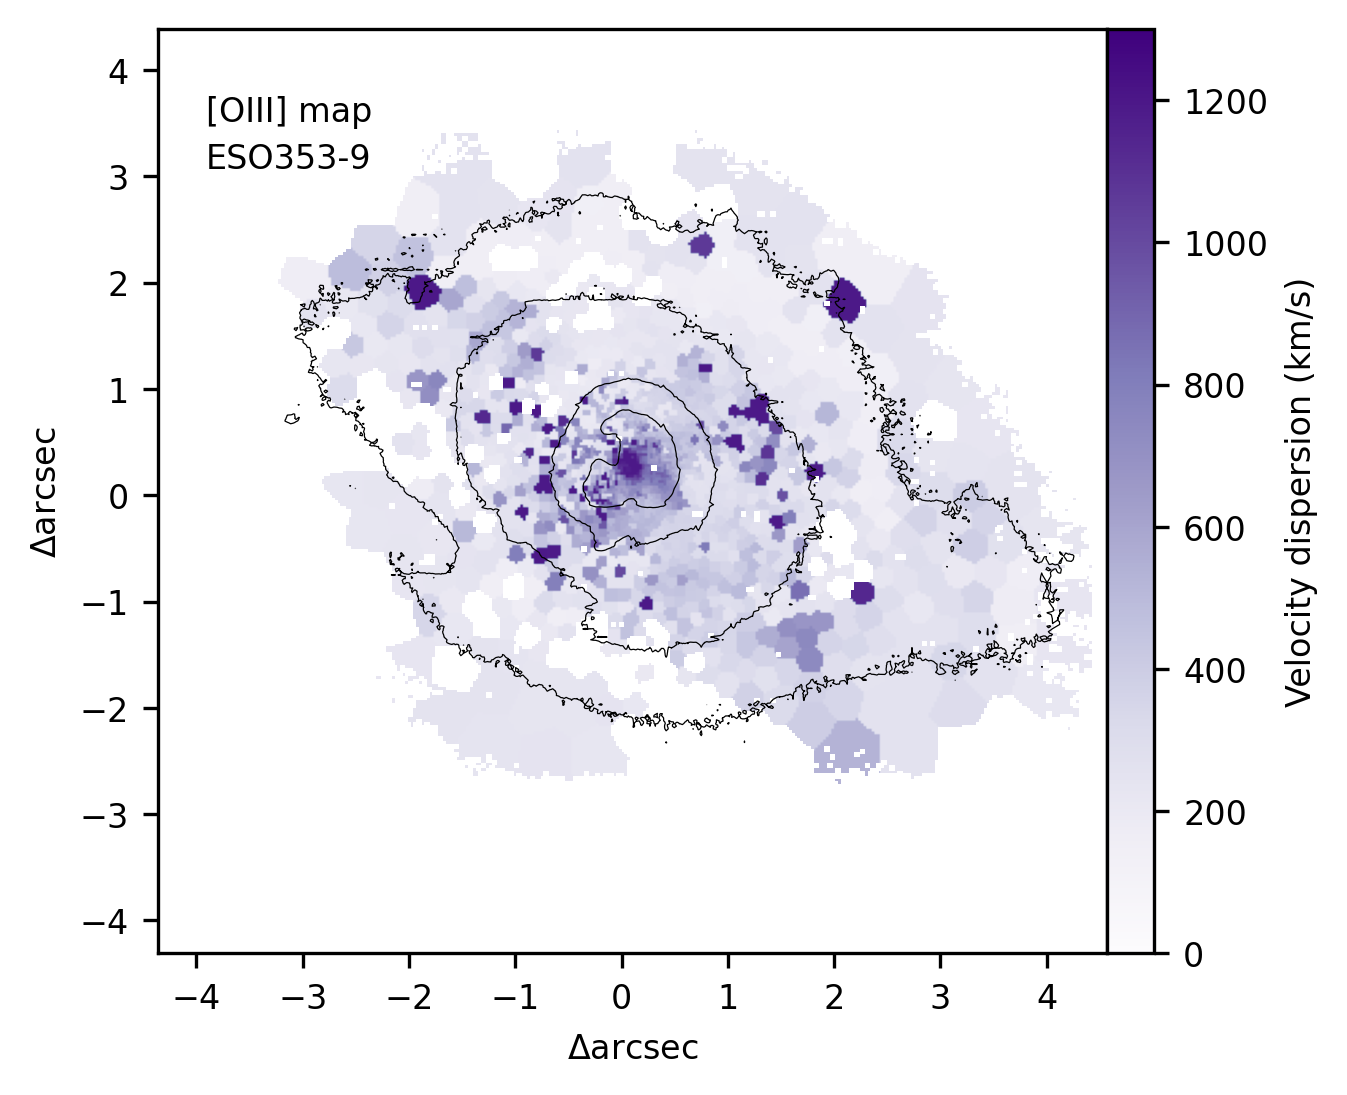

In [65]:
from astropy.stats import sigma_clipped_stats

image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = result[:,3]

fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=0
vmax=1300
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(image), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"Velocity dispersion (km/s)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=4.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"[OIII]"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
fig.savefig(datapath+"/fig/{}_vdisp_broad_map.pdf".format(line))

array([1.27174434])

In [47]:
np.nanmedian(EBV)

0.877043260310216

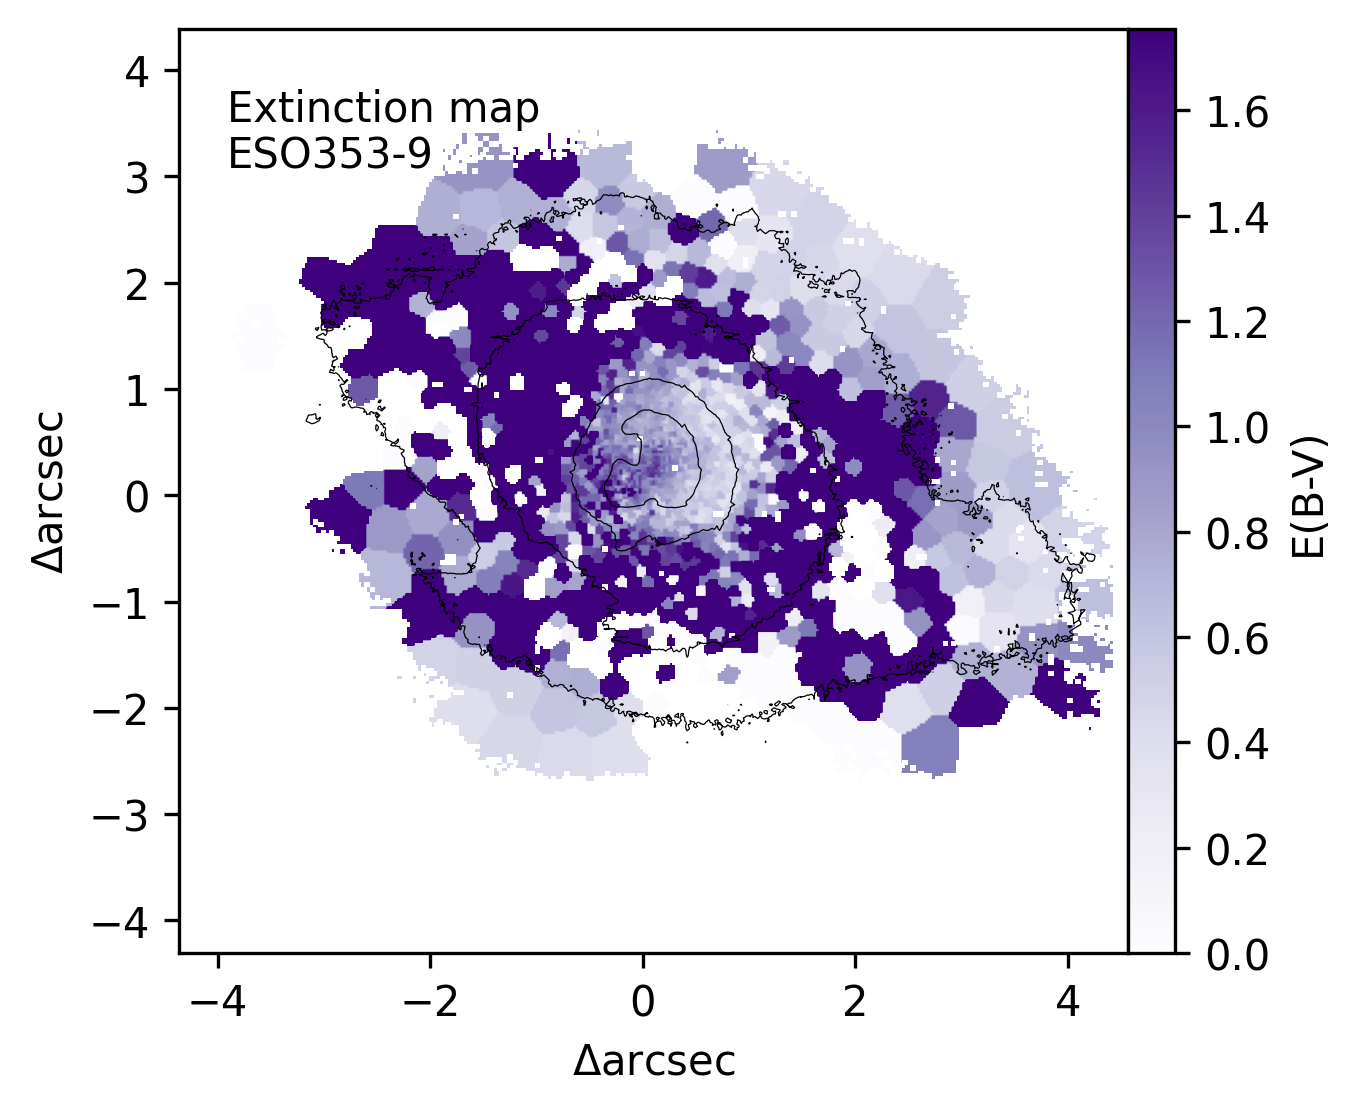

In [50]:
from astropy.stats import sigma_clipped_stats
from dust_attenuation.averages import C00
Cex=C00()

EBV = np.full( (npixels_x, npixels_y), np.nan )

#2.5/1.163*np.log10

EBV[i,j] = 2.5/(Cex.k_lambda(x=[0.486268])-Cex.k_lambda(x=[0.656461]))*np.log10(result[:,4]/2.68)

fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=0
vmax=2*np.nanmedian(EBV)
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(EBV), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"E(B-V)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=4.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"Extinction"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
fig.savefig(datapath+"/fig/MUSE_extinction_map.pdf")

In [541]:
np.nanmedian(10**(Cex.k_lambda(x=[0.6564])*0.77))

363.3875826681166

In [624]:
np.nansum(10**Ha_SFR)

17088612.67796457

In [58]:
np.nanstd(Ha_SFR)

nan

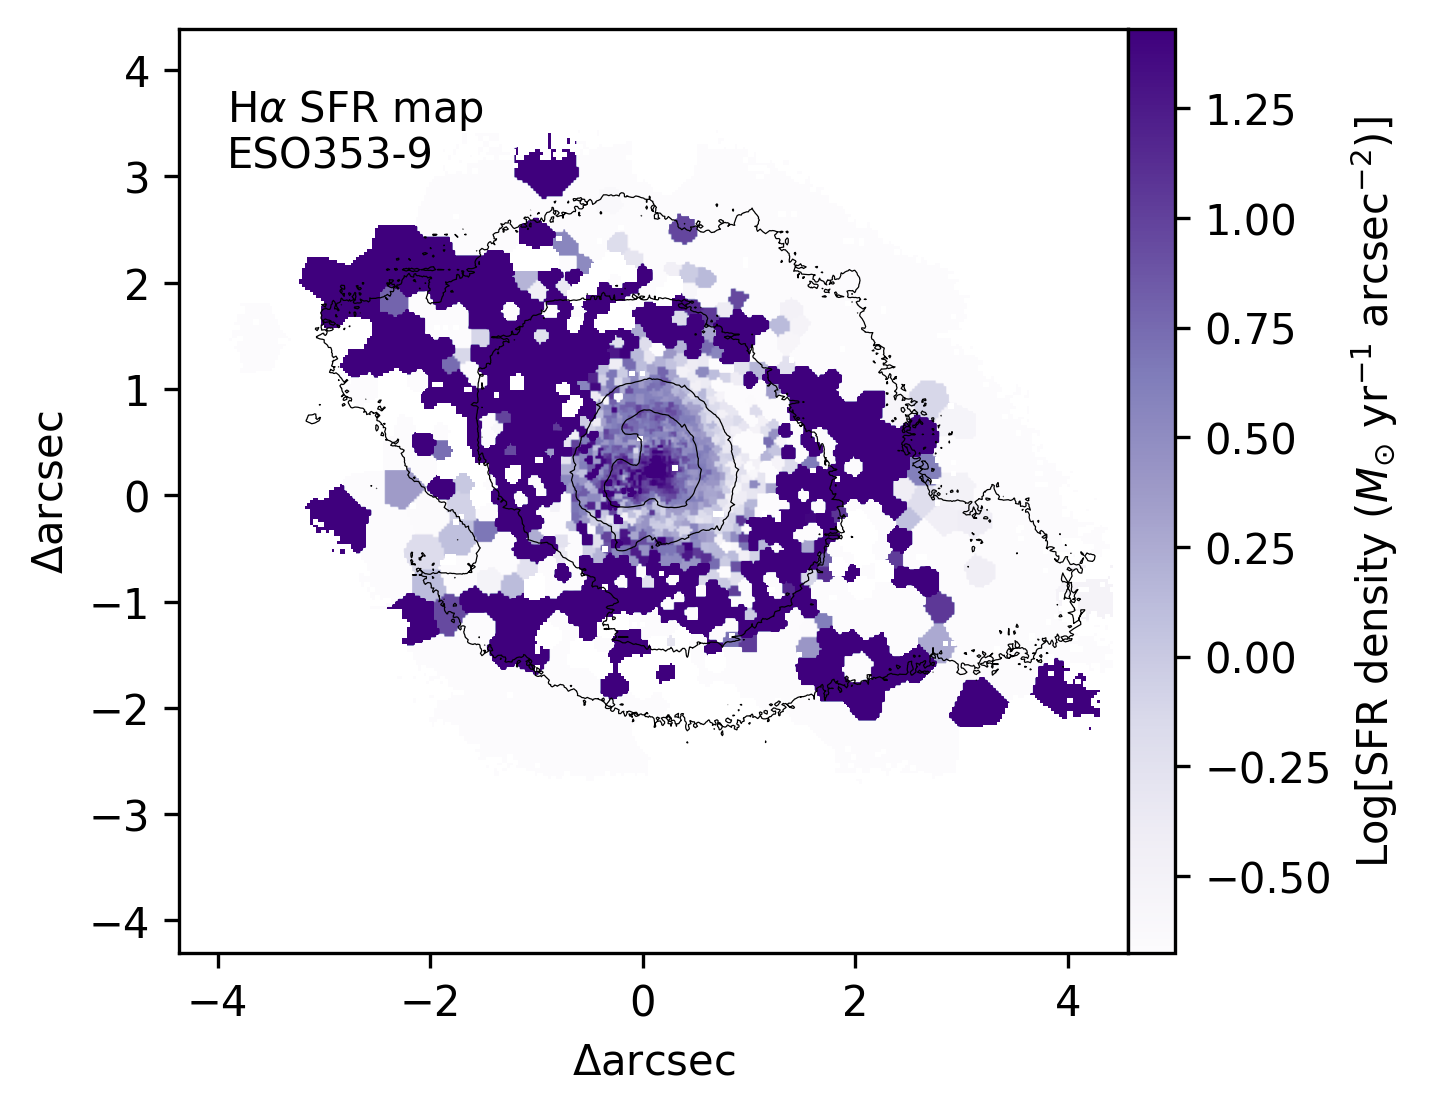

In [61]:
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import Planck18
#EBV = np.full( (npixels_x, npixels_y), np.nan )

#2.5/1.163*np.log10

#EBV[i,j] = 2.5/(Cex.k_lambda(x=[0.486268])-Cex.k_lambda(x=[0.656461]))*np.log10(result[:,4]/2.68)

Sld=Planck18.luminosity_distance(z=0.03145).to(u.cm).value**2*4*np.pi
image = np.full( (npixels_x, npixels_y), np.nan )
image[i,j] = result[:,5]*1e-20
EBV[EBV<0]=0
Ha_SFR=np.log10(image*Sld*10**(0.4*Cex.k_lambda(x=[0.6564])*EBV)/10**41.27)#
#Ha_SFR=np.log10(image*10**(0.4*Cex.k_lambda(x=[0.6564])*EBV)*1e20)#

fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)
#plt.subplots_adjust(wspace=0.5)
#plt.subplot(111)
#mag=-2.5*np.log10(signal/np.sum(signal).ravel())
vmin=np.nanmedian(Ha_SFR)
vmax=np.nanmax(Ha_SFR)*0.1
cmap = plt.cm.Purples
cmap.set_bad(color='none') 
im=ax.imshow(np.rot90(Ha_SFR), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
cb=fig.colorbar(im, cax=cax)
cb.set_label(r"Log[SFR density ($M_{\odot}\rm ~yr^{-1}~arcsec^{-2}$)]")
#cb.set_label(r"Log[F$_\mathrm{H\alpha}$ ($10^{-20}\rm~erg~s^{-1}~cm^{-2}~arcsec^{-2}$)]")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=4.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"H$\alpha$ SFR"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
fig.savefig(datapath+"/fig/MUSE_SFR_map.pdf")

In [536]:
np.nanmax(Cex.k_lambda(x=[0.6564])*EBV)

18.338505167295768

In [259]:
10**(Cex.k_lambda(x=[0.658528])-Cex.k_lambda(x=[0.656461]))

array([0.97001319])

color: orange
length of data: (4077,)
color: red
length of data: (22394,)
color: [0.2, 0.4, 0.6]
length of data: (21634,)


(-1.2, 1.2)

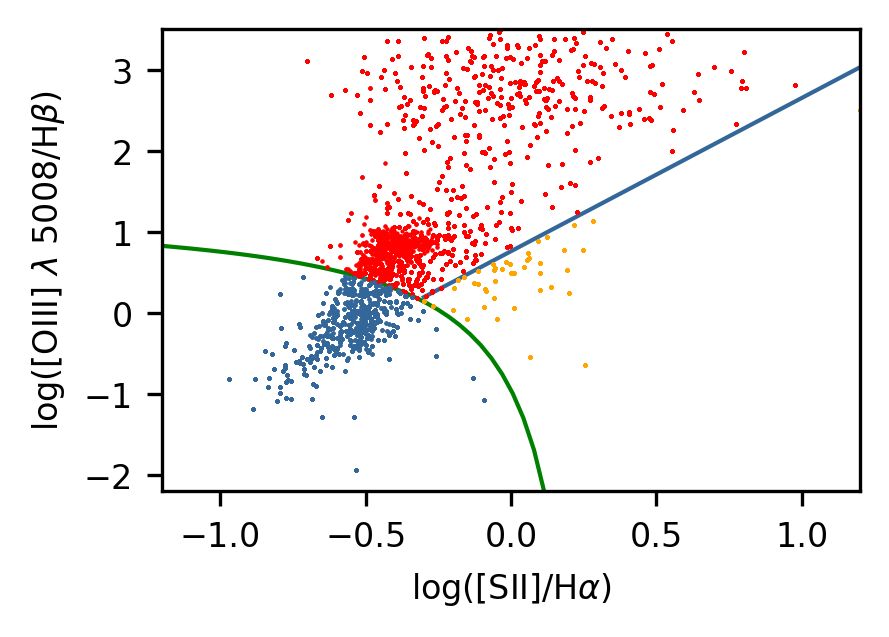

In [15]:
from dust_attenuation.averages import C00
Cex=C00()
fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)

Ax=Cex.k_lambda(x=[0.6725])-Cex.k_lambda(x=[0.656461])

Ay=Cex.k_lambda(x=[0.500824])-Cex.k_lambda(x=[0.486268])

xBPT=np.log10(result[:,4]/result[:,2]*10**Ax)

yBPT=np.log10(result[:,1]/result[:,3]*10**Ay)

# Kewley+01 ------------------------------------------
XK01 = np.linspace(-1.5,0.3)
YK01 = (0.72/( XK01  - 0.32  )) + 1.30

# Kewley+06 --------------------------------------
XK06 = np.linspace(-0.30,1.5)
YK06 = 1.89*XK06 + 0.76

# Regions --------------------------------------------
color=["orange","red",[0.2,0.4,0.6],"green"]


ax.plot(XK01,   YK01, '-' , color='green', lw=1, label='Kewley+01'    ) # Kewley+01
ax.plot(XK06, YK06, '-', color=color[2], lw=1, label='Kewley+06') # Schawinski+07
#ax.plot(Xkauff, Ykauff, '--', color='m', lw=1, label='Kauffmann+03' ) # Kauffmann+03
ax.set_xlabel(r'log([SII]/H$\alpha$)',fontsize=8)
ax.set_ylabel(r'log([OIII] $\lambda$ 5008/H$\beta$)',fontsize=8)
#ax.scatter(xBPT,yBPT,s=0.5)
xxmin, xxmax         = -1.2, 1.2   # Define the maximum and minimum limit in X-axis
yymin, yymax         = -2.2, 3.5   # Define the maximum and minimum limit in Y-axis
ax.tick_params(labelsize = 8)
ax.legend
#ax.set_yscale("log")



LINERs=(xBPT>np.min(XK06)) & (yBPT<(1.89*xBPT+0.76)) & (yBPT>((0.72/( xBPT  - 0.32  )) + 1.30))

AGNs= (xBPT>np.min(XK06)) & (yBPT>(1.89*xBPT+0.76))|(xBPT<np.min(XK06)) & (yBPT>(0.72/( xBPT  - 0.32  ) + 1.30))

SF =  (yBPT<(0.72/( xBPT  - 0.32  ) + 1.30)) & (xBPT < np.max(XK01))

#Composite = (yBPT > 0.61/(xBPT -0.05) + 1.3) & (yBPT<(0.61/( xBPT  - 0.47  ) + 1.19))

kind=np.array([LINERs, AGNs, SF])
for ii in range(3):
    print("color:",color[ii])
    print("length of data:",xBPT[kind[ii,:]].shape)
    ax.errorbar(xBPT[kind[ii,:]],yBPT[kind[ii,:]],fmt="o",mfc=color[ii],ms=1.0,mec="none")

ax.set_ylim(yymin, yymax)
ax.set_xlim(xxmin, xxmax)


color: orange
length of data: (7492,)
color: red
length of data: (21168,)
color: [0.2, 0.4, 0.6]
length of data: (11450,)
color: green
length of data: (8640,)


(-1.2, 1.2)

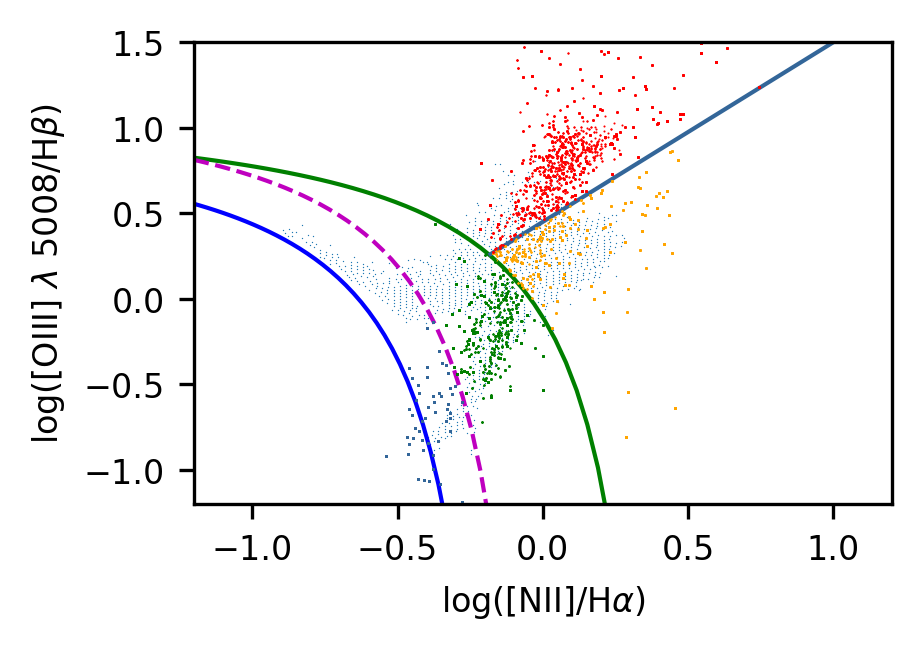

In [16]:

fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)

Ax=Cex.k_lambda(x=[0.658528])-Cex.k_lambda(x=[0.656461])

Ay=Cex.k_lambda(x=[0.500824])-Cex.k_lambda(x=[0.486268])

xBPT=np.log10(result[:,0]/result[:,2]*10**Ax)

yBPT=np.log10(result[:,1]/result[:,3]*10**Ay)

# Kewley+01 ------------------------------------------
Xkew = np.linspace(-1.5,0.3)
Ykew = (0.61/( Xkew  - 0.47  )) + 1.19

Xkew2 = np.linspace(-1.5,-0.2)

Ykew2=(0.61/( Xkew2  + 0.08  )) + 1.1
# Schawinski+07 --------------------------------------
XSch = np.linspace(-0.180,1.5)
YSch = 1.05*XSch + 0.45

# Kauffmann+03 ---------------------------------------
Xkauff = np.linspace(-1.5,0.)
Ykauff = 0.61/(Xkauff -0.05) + 1.3

# Regions --------------------------------------------
color=["orange","red",[0.2,0.4,0.6],"green"]


ax.plot(Xkew,   Ykew, '-' , color='green', lw=1, label='Kewley+01'    ) # Kewley+01
ax.plot(Xkew2,   Ykew2, '-' , color='blue', lw=1, label='Kewley+13'    ) # Kewley+01

ax.plot(XSch, YSch, '-', color=color[2], lw=1, label='Schawinski+07') # Schawinski+07
ax.plot(Xkauff, Ykauff, '--', color='m', lw=1, label='Kauffmann+03' ) # Kauffmann+03
ax.set_xlabel(r'log([NII]/H$\alpha$)',fontsize=8)
ax.set_ylabel(r'log([OIII] $\lambda$ 5008/H$\beta$)',fontsize=8)
#ax.scatter(xBPT,yBPT,s=0.5)
xxmin, xxmax         = -1.2, 1.2   # Define the maximum and minimum limit in X-axis
yymin, yymax         = -1.2, 1.5   # Define the maximum and minimum limit in Y-axis
ax.tick_params(labelsize = 8)
ax.legend
#ax.set_yscale("log")
NII = np.linspace(-0.5, 0.5)
BPT=np.genfromtxt("/disk/bifrost/yuanze/multiAGN/Line.csv",delimiter=",")
ax.scatter(BPT[:,0],BPT[:,1],s=0.1,lw=0)
#plt.scatter(data['log_NII_Ha'], data['log_OIII_Hb'],
#            c="black", s=0.1, lw=0)
#NII = np.linspace(-2.0, 0.35)
#ax.plot(NII, log_OIII_Hb_NII(NII), '-k')
#ax.plot(NII, log_OIII_Hb_NII(NII, 0.1), '--k')
#ax.plot(NII, log_OIII_Hb_NII(NII, -0.1), '--k')

LINERs=(xBPT>np.min(XSch)) & (yBPT<(1.05*xBPT+0.45)) & (yBPT>((0.61/( xBPT  - 0.47  )) + 1.19))

AGNs= (xBPT>np.min(XSch)) & (yBPT>(1.05*xBPT+0.45))|(xBPT<np.min(XSch)) & (yBPT>(0.61/( xBPT  - 0.47  ) + 1.19))

SF = (xBPT<np.min(XSch)) & (yBPT<(0.61/(xBPT -0.05) + 1.3)) & (xBPT < np.max(Xkauff))

Composite = (yBPT > 0.61/(xBPT -0.05) + 1.3) & (yBPT<(0.61/( xBPT  - 0.47  ) + 1.19)) & (xBPT < np.max(Xkew))

kind=np.array([LINERs, AGNs, SF,Composite])
for ii in range(4):
    print("color:",color[ii])
    print("length of data:",xBPT[kind[ii,:]].shape)
    ax.errorbar(xBPT[kind[ii,:]],yBPT[kind[ii,:]],fmt="o",mfc=color[ii],ms=0.5,mec="none")

ax.set_ylim(yymin, yymax)
ax.set_xlim(xxmin, xxmax)


In [738]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_sdss_spectrum
from astroML.datasets.tools.sdss_fits import log_OIII_Hb_NII

data = fetch_sdss_spectrum()

i = np.where((data['lineindex_cln'] == 4) | (data['lineindex_cln'] == 5))

plt.scatter(data['log_NII_Ha'], data['log_OIII_Hb'],
            c=data['lineindex_cln'], s=9, lw=0)

NII = np.linspace(-2.0, 0.35)
plt.plot(NII, log_OIII_Hb_NII(NII), '-k')
plt.plot(NII, log_OIII_Hb_NII(NII, 0.1), '--k')
plt.plot(NII, log_OIII_Hb_NII(NII, -0.1), '--k')
plt.xlim(-2.0, 1.0)
plt.ylim(-1.2, 1.5)

plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.show()

TypeError: fetch_sdss_spectrum() missing 3 required positional arguments: 'plate', 'mjd', and 'fiber'

In [698]:
data.keys()

KeysView(NpzFile '/disk/bifrost/yuanze/astroML_data/spec4000.npz' with keys: norms, spectra, log_OIII_Hb, zerr, mu...)

(-1.2, 1.2)

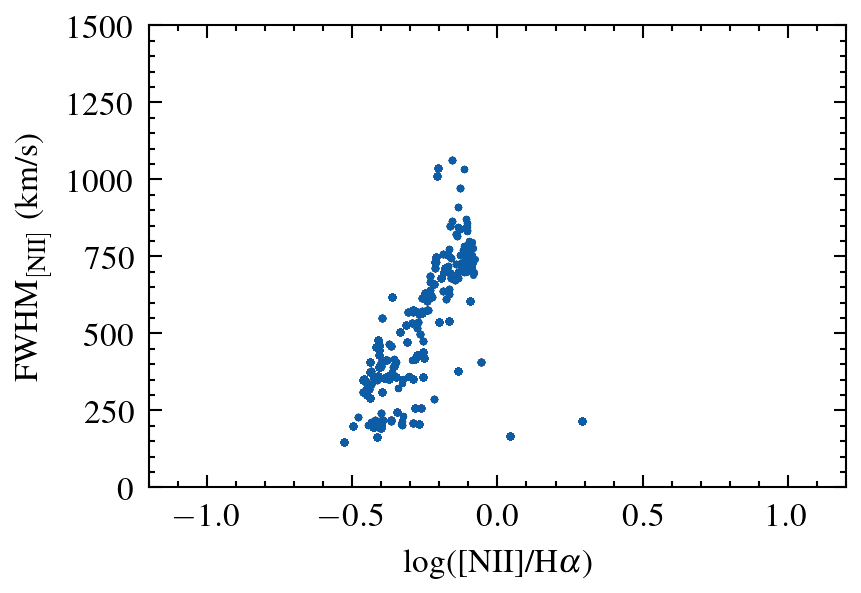

In [615]:

fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)

Ax=Cex.k_lambda(x=[0.658528])-Cex.k_lambda(x=[0.656461])

#Ay=Cex.k_lambda(x=[0.500824])-Cex.k_lambda(x=[0.486268])



xBPT=np.log10(result[:,0]/result[:,2]*10**Ax)



yBPT=result[:,5]

ax.scatter(xBPT,yBPT,s=0.5)


ax.set_xlabel(r'log([NII]/H$\alpha$)',fontsize=8)
ax.set_ylabel(r'FWHM$_\mathrm{[NII]}$ (km/s)',fontsize=8)
#ax.scatter(xBPT,yBPT,s=0.5)
xxmin, xxmax         = -1.2, 1.2   # Define the maximum and minimum limit in X-axis
yymin, yymax         = 0, 1500   # Define the maximum and minimum limit in Y-axis
ax.tick_params(labelsize = 8)
ax.legend
#ax.set_yscale("log")
ax.set_ylim(yymin, yymax)
ax.set_xlim(xxmin, xxmax)


In [19]:
np.nanmax(np.log10( FLUX ))

2.2429696546436957

Dir exists


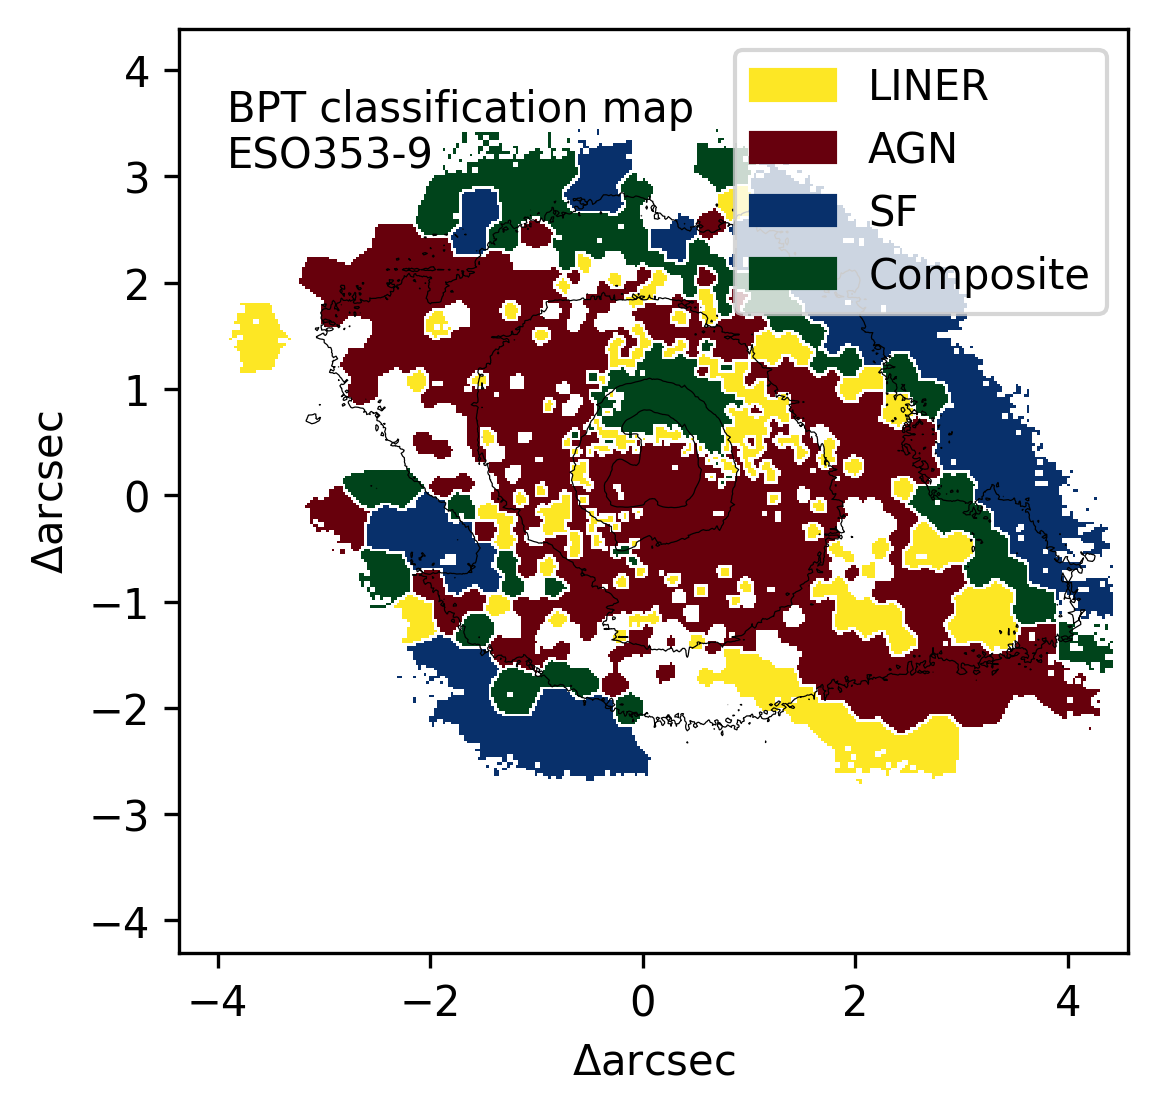

In [25]:
from astropy.stats import sigma_clipped_stats
import matplotlib.patches as mpatches


ramask=np.full((npixels_x, npixels_y), np.nan )
blank_image=np.full((npixels_x, npixels_y), np.nan )
color=[np.array([0.1, 0.2, 0.5]),np.array([0.1, 0.8, 0.3]),np.array([0.1, 0.8, 0.5]),np.array([0.8, 0.3, 0.1])]
cmaps=[plt.cm.viridis, plt.cm.Reds, plt.cm.Blues, plt.cm.Greens]


fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)

vmin=0
vmax=1.
legend_patches=[]
labels=["LINER", "AGN", "SF","Composite"]
for ii in range(4):
    blank_image=np.full((npixels_x, npixels_y), np.nan )
    ramask=np.full((npixels_x, npixels_y), False )
    ramask[i,j]= kind[ii,:]
    # BPTclass.append(ramask.copy())
    blank_image[ramask]=1
    cmap=cmaps[ii]
    cmap.set_bad(color='none') 
    rescmap=cmap.resampled(10)
    legend_patches.append(mpatches.Patch(color=rescmap(10)[:3], label=labels[ii]))
    ax.imshow(np.rot90(blank_image),cmap=cmap, interpolation=None,vmin=vmin,vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )



# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.0, 1))


#im=ax.imshow(np.rot90(BPTclass[0]), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            #extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
#divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
#cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
#cb=fig.colorbar(im, cax=cax)
#cb.set_label(r"E(B-V)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=4.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX )), 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"BPT classification"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
try:
    os.mkdir(datapath+"/fig")
except:
    print("Dir exists")
fig.savefig(datapath+"/fig/MUSE_BPT_map.pdf")

In [ ]:
from astropy.stats import sigma_clipped_stats
import matplotlib.patches as mpatches


ramask=np.full((npixels_x, npixels_y), np.nan )
blank_image=np.full((npixels_x, npixels_y), np.nan )
color=[np.array([0.1, 0.2, 0.5]),np.array([0.1, 0.8, 0.3]),np.array([0.1, 0.8, 0.5]),np.array([0.8, 0.3, 0.1])]
cmaps=[plt.cm.viridis, plt.cm.Reds, plt.cm.Blues, plt.cm.Greens]


fig,ax=plt.subplots(1,1,figsize=(8, 4),dpi=300)

vmin=0
vmax=1.
legend_patches=[]
labels=["LINER", "AGN", "SF"]
for ii in range(3):
    blank_image=np.full((npixels_x, npixels_y), np.nan )
    ramask=np.full((npixels_x, npixels_y), False )
    ramask[i,j]= kind[ii,:]
    # BPTclass.append(ramask.copy())
    blank_image[ramask]=1
    cmap=cmaps[ii]
    cmap.set_bad(color='none') 
    rescmap=cmap.resampled(10)
    legend_patches.append(mpatches.Patch(color=rescmap(10)[:3], label=labels[ii]))
    ax.imshow(np.rot90(blank_image),cmap=cmap, interpolation=None,vmin=vmin,vmax=vmax, \
            extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )



# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.0, 1))


#im=ax.imshow(np.rot90(BPTclass[0]), cmap=cmap, interpolation=None, vmin=vmin, vmax=vmax, \
            #extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )
#divider = make_axes_locatable(ax)
# Append axes to the right of ax, with 2% width and no padding
#cax = divider.append_axes("right", size="5%", pad=0.0)

# Create a colorbar in the new axes
#cb=fig.colorbar(im, cax=cax)
#cb.set_label(r"E(B-V)")

XY_Triangulation = Triangulation(X-pixelsize/2, Y-pixelsize/2)
XY_Triangulation.set_mask( TriAnalyzer(XY_Triangulation).get_flat_tri_mask(0.01) )
contour_offset=5.5
levels = np.arange( np.nanmin(np.log10( FLUX )) + contour_offset, np.nanmax(np.log10( FLUX ))-0.4, 0.4 )
ax.tricontour(XY_Triangulation, np.log10(FLUX), levels=levels, linewidths=0.3, colors='k')#ax=plt.gca()

ax.set_xlabel(r"$\Delta$arcsec")
ax.set_ylabel(r"$\Delta$arcsec")
RApix=[3.4,4.4,5.3]
Decpix=[1.8,4.4,3.]
#for io in range(3):
#    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
#line=r"H$\alpha$"
line=r"BPT classification"
ax.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax.transAxes)
ax.text(0.05,0.9,"{} map".format(line),color="k",transform=ax.transAxes)

#resolution=mpatches.Ellipse((0.9,0.9),s.pixelsize,s.pixelsize,color='red',fill=True,transform=ax.transAxes)
#ax.add_artist(resolution)
#ax.plot(xbin[tbin], ybin[tbin],"+",c="b",ms=10,lw=0.01)
    #ax.set_xlim([2.5,5.5])
#ax.set_ylim([2.5,5.5])
#plt.tricontour(s.x, s.y, mag, levels=levels)
fig.savefig(datapath+"/fig/MUSE_SIIBPT_map.pdf")

In [713]:
l

NameError: name 'ld' is not defined

In [423]:
nbins

211

In [63]:
"""
fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name('OIII5007c', 'narrow')
print("Narrow [OIII]5007:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("S/N", np.round(snr, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")

fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name('NII6549w', 'narrow')

print("Narrow Hb:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("S/N", np.round(snr, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")
"""
from plotbin.display_bins import display_bins
from matplotlib.gridspec import GridSpec
#tbin=225

line="OIII5007"
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
try:
    os.mkdir(datapath+f"/field_scan")
except:
    print("Dir exists")
for tbin in range(nbins):
    q=qlist[tbin]
    fig=plt.figure(figsize=(8,4), dpi=300)
    gs=GridSpec(2,2,wspace=None)
    ax1=fig.add_subplot(gs[0,0])
    ax2=fig.add_subplot(gs[1,0])
    ax3=fig.add_subplot(gs[:,1])
    #q=q_mle
    
    #q.set_mpl_style( tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0)
    
    if q.MCMC:
        gauss_result = q.gauss_result[::2]
    else:
        gauss_result = q.gauss_result
    #plt.subplot(111)
    # Plot individual line components
    for p in range(int(len(gauss_result) / 3)):
        if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
            color = 'g'  # narrow
        else:
            color = 'r'  # broad
        ax1.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)
        ax2.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)
    
    # Plot total line model
    ax1.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
    ax1.step(q.wave, q.line_flux, 'k',lw=0.5)
    
    ax2.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
    ax2.step(q.wave, q.line_flux, 'k',lw=0.5)
    #ax.step(q.wave,q.err)
    ax1.set_xlim(6400, 6900)
    ax2.set_xlim(4800, 5200)
    yup_1=np.nanmax(q.line_flux[q.wave>6000])
    yup_2=np.nanmax(q.line_flux[q.wave<5200])
    ax1.set_ylim(1e-4, yup_1)
    ax2.set_ylim(1e-4, yup_2)
    #ax.set_yscale("log")
    ax2.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize=10)
    ax2.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize=10)
    #plt.subplot(122)
    #
    #mag=-2.5*np.log10(signal/np.sum(signal).ravel())
    #levels=[8,9,10,13,15,18,20,25,30,35,40]
    for ii in range(4):
        blank_image=np.full((npixels_x, npixels_y), np.nan )
        ramask=np.full((npixels_x, npixels_y), False )
        ramask[i,j]= kind[ii,:]
        # BPTclass.append(ramask.copy())
        blank_image[ramask]=1
        cmap=cmaps[ii]
        cmap.set_bad(color='none') 
        rescmap=cmap.resampled(10)
        legend_patches.append(mpatches.Patch(color=rescmap(10)[:3], label=labels[ii]))
        ax3.imshow(np.rot90(blank_image),cmap=cmap, interpolation=None,vmin=vmin,vmax=vmax, \
                extent=[xmin-pixelsize/2, xmax+pixelsize/2, ymin-pixelsize/2, ymax+pixelsize/2] )

    #ax=plt.gca()
    ax3.set_xlabel(r"$\Delta$arcsec")
    ax3.set_ylabel(r"$\Delta$arcsec")
    #RApix=[3.4,4.4,5.3]
    #Decpix=[1.8,4.4,3.]
    #for io in range(3):
    #    ax.plot(RApix[io], Decpix[io],"+",c="r",ms=10,lw=0.01)
    ax3.text(0.05,0.85,"{}".format(psname1+psname2),color="k",transform=ax3.transAxes)
    ax3.text(0.05,0.9,"{} BPT map".format(line),color="k",transform=ax3.transAxes)
    ind=(binNum_long==tbin)
    px=np.mean(X[ind])
    py=np.mean(Y[ind])
    ax3.plot(px, py,"+",c="m",ms=10,lw=0.01)
    fig.savefig(datapath+f"/field_scan/bin{tbin:d}.pdf")
    plt.tight_layout()
    plt.close()



array([ True,  True,  True, ..., False, False, False])

In [191]:
from astropy.cosmology import Planck18
Planck18.kpc_proper_per_arcmin(0.03145).value/60*2.7

1.755419738402185

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-490.84333961420725, 50201.69264424604)

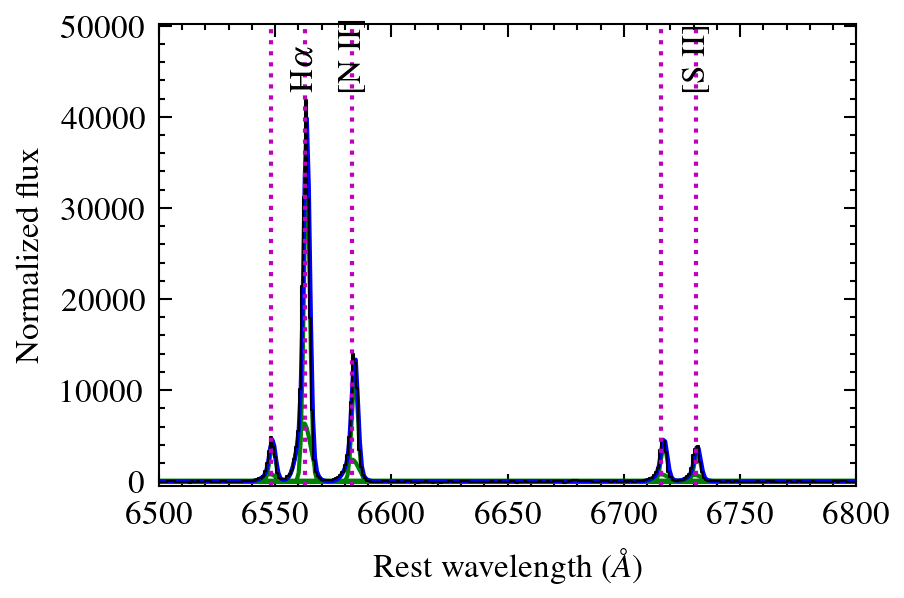

In [160]:
lines={'[N II]':[6548.,6583.],"[S II]":[6716.,6731.] ,'[O III]':[4959,5007],'[O II]':[3727], r"H$\alpha$":[6563], r"H$\beta$":[4861.],"CaII":[8498, 8542, 8662]}#,"Fe II":[6491.28,6385.45,6598.3]}
import scienceplots
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
bin_sel=157

q=qlist[bin_sel]
rlinec= (1+0.0312)/(1+0.0316)


if q.MCMC:
    gauss_result = q.gauss_result[::2]
else:
    gauss_result = q.gauss_result

# Plot individual line components
fig, ax = plt.subplots(1, 1,figsize=(3,2), dpi=300)


for p in range(int(len(gauss_result) / 3)):
    if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q.wave*rlinec, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

    



ax.plot(q.wave*rlinec, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
ax.step(q.wave*rlinec, q.line_flux, 'k',lw=0.5)
#ax.plot(np.exp(Lambda)*rlinec,Spectra[bin_sel,:],lw=0.5,label="Data")
#ax.plot(np.exp(kinLambda)*rlinec,kinBestfit[bin_sel,:],lw=0.5,label="Model")
ax.set_ylabel("Normalized flux")
ax.set_xlabel(r"Rest wavelength ($\AA$)")
xlow=6500
xhigh=6800
yup=np.max(q.line_flux)*1.2
ylow=np.min(q.line_flux)*0.8

keys=lines.keys()
for ind,key in enumerate(keys):
    for line in lines[key]:
        if line < xhigh and line > xlow:
            ax.axvline(line,ls=":",c="m")
#            masktmp = (x.value < ((1+redshift)*line*(1+dlam))) & (x.value > ((1+redshift)*line*(1-dlam)))
#            mask= mask | masktmp
           # print(x[mask])
    if line < xhigh and line > xlow:
        ax.text(line, 0.85*yup,key, rotation=90,verticalalignment='bottom',horizontalalignment='center')

#rstring=rf"V={result[idx][0][0]:.1f}$\pm${result[idx][0][2]:.1f}, $\sigma$={result[idx][0][1]:.1f}$\pm${result[idx][0][3]:.1f} km/s"
#ax.text(0.05,0.97, rstring, color='black', ha='left', va='top',transform=ax.transAxes)
ax.legend(loc="lower left")
ax.set_xlim([xlow,xhigh])
ax.set_ylim([ylow,yup])
#fig.savefig(datapath+f"/fig/fitted_spec_kin_obj{obj}.pdf")